In [74]:
import torch
import torch.nn as nn
from d2l import torch as d2l
import pandas as pd
import os

import numpy as np

In [275]:
d2l.DATA_HUB['ml-100k'] = (
    'https://files.grouplens.org/datasets/movielens/ml-100k.zip',
    'cd4dcac4241c8a4ad7badc7ca635da8a69dddb83')

#@save
def read_data_ml100k():
    data_dir = d2l.download_extract('ml-100k')
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv(os.path.join(data_dir, 'u.data'), sep='\t',
                       names=names, engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data, num_users, num_items

data = read_data_ml100k()
data[0]["rating"].mean()

3.52986

In [70]:
def load_data_ml100k(data, num_users, num_items, feedback='explicit'):
    users, items, scores = [], [], []
    inter = np.zeros((num_items, num_users)) if feedback == 'explicit' else {}
    for line in data.itertuples():
        user_index, item_index = int(line[1] - 1), int(line[2] - 1)
        score = int(line[3]) if feedback == 'explicit' else 1
        users.append(user_index)
        items.append(item_index)
        scores.append(score)
        if feedback == 'implicit':
            inter.setdefault(user_index, []).append(item_index)
        else:
            inter[item_index, user_index] = score
    return users, items, scores, inter

In [71]:
#@save
def split_data_ml100k(data, num_users, num_items,
                      split_mode='random', test_ratio=0.1):
    """Split the dataset in random mode or seq-aware mode."""
    if split_mode == 'seq-aware':
        train_items, test_items, train_list = {}, {}, []
        for line in data.itertuples():
            u, i, rating, time = line[1], line[2], line[3], line[4]
            train_items.setdefault(u, []).append((u, i, rating, time))
            if u not in test_items or test_items[u][-1] < time:
                test_items[u] = (i, rating, time)
        for u in range(1, num_users + 1):
            train_list.extend(sorted(train_items[u], key=lambda k: k[3]))
        test_data = [(key, *value) for key, value in test_items.items()]
        train_data = [item for item in train_list if item not in test_data]
        train_data = pd.DataFrame(train_data)
        test_data = pd.DataFrame(test_data)
    else:
        mask = [True if x == 1 else False for x in np.random.uniform(
            0, 1, (len(data))) < 1 - test_ratio]
        neg_mask = [not x for x in mask]
        train_data, test_data = data[mask], data[neg_mask]
    return train_data, test_data

In [116]:
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader

def split_and_load_ml100k(split_mode='seq-aware', feedback='explicit',
                          test_ratio=0.1, batch_size=256):
    data, num_users, num_items = read_data_ml100k()
    train_data, test_data = split_data_ml100k(
        data, num_users, num_items, split_mode, test_ratio)
    train_u, train_i, train_r, _ = load_data_ml100k(
        train_data, num_users, num_items, feedback)
    test_u, test_i, test_r, _ = load_data_ml100k(
        test_data, num_users, num_items, feedback)

    train_set = TensorDataset(
        torch.tensor(np.array([train_u, train_i]).T),
        torch.tensor(np.array(train_r))
    )
    test_set = TensorDataset(
        torch.tensor(np.array([test_u, test_i]).T),
        torch.tensor(np.array(test_r))
    )

    train_iter = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    test_iter = DataLoader(test_set, batch_size=batch_size, shuffle=True, drop_last=True)

    return num_users, num_items, train_iter, test_iter

u = [1, 2, 3, 4, 5]
i = [1, 2, 3, 4, 5]

np.array([u, i]).T

array([[1, 1],
       [2, 2],
       [3, 3],
       [4, 4],
       [5, 5]])

In [118]:
num_users, num_items, train_iter, test_iter = split_and_load_ml100k()

In [271]:
class MF(nn.Module):
    def __init__(self, num_factors, num_users, num_items, global_mean, **kwargs):
        super(MF, self).__init__(**kwargs)
        self.user_factors = nn.Embedding(num_embeddings=num_users, embedding_dim=num_factors) # sparse=True ? 
        self.item_factors = nn.Embedding(num_embeddings=num_items, embedding_dim=num_factors)
        self.user_biases = nn.Embedding(num_users, 1)
        self.item_biases = nn.Embedding(num_items, 1)

        self.mu = torch.tensor(global_mean)

    def forward(self, user_id, item_id):
        user_factors = self.user_factors(user_id)
        item_factors = self.item_factors(item_id)
        b_u = self.user_biases(user_id)
        b_i = self.item_biases(item_id)
        outputs = (user_factors * item_factors).sum(axis=1) + np.squeeze(b_u) + np.squeeze(b_i) + self.mu
        outputs = torch.clamp(outputs, min=1.0, max=5.5)

        return outputs.flatten()

model_test_eval = MF(10, num_users, num_items, 3.5)

# for u_i, r in train_iter:
#     print(model(u_i[:, 0], u_i[:, 1]))
#     break

In [272]:
def evaluator(net, test_iter):
    criterion = nn.MSELoss()

    rmse_list = []
    for idx, (u_i, ratings) in enumerate(test_iter):
        loss = torch.sqrt(criterion(ratings, net(u_i[:,0], u_i[:,1])))
        rmse_list.append(loss.detach())

    return float(np.mean(np.array(rmse_list)))

model_test_eval = MF(10, num_users, num_items, 3.5)

# test_iter = [
#     torch.tensor(
#         [
#             [0, 1, 2], # users
#             [0, 1, 2], # items
#             [1, 3, 5]  # ratings
#         ]
#     )
# ]

# for idx, (u_i, ratings) in enumerate(test_iter):
#     print(u_i[:,0])
#     print(u_i[:,1])
#     print(ratings)
    
#     break

evaluator(model_test_eval, test_iter)

2.179969310760498

In [259]:
num_users, num_items, train_iter, test_iter = split_and_load_ml100k(batch_size=512)

In [276]:
model = MF(5, num_users, num_items, 3.52986)
model.mu.requires_grad = False

num_epochs = 200
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# adagrad_loss = torch.optim.Adagrad(model.parameters(), lr=1e-3)
is_val = True

In [277]:
train_loss = []
test_loss  = []

for epoch in range(num_epochs):
    for idx, (u_i, ratings) in enumerate(train_iter):
        # Set gradients to zero
        optimizer.zero_grad()

        # Predict and calculate loss
        prediction = model(u_i[:, 0], u_i[:, 1])
        loss = loss_func(prediction, ratings.float())

        # Backpropagate
        loss.backward()

        # Update the parameters
        optimizer.step()

    train_loss.append(evaluator(model, train_iter))
    test_loss.append(evaluator(model, test_iter))

    if is_val:
        print("Epoch:", epoch)
        print("Train loss", train_loss[-1])
        print("Test loss", test_loss[-1])

Epoch: 0
Train loss 1.990268588066101
Test loss 2.049330711364746
Epoch: 1
Train loss 1.9674739837646484
Test loss 2.0770435333251953
Epoch: 2
Train loss 1.9442012310028076
Test loss 2.0814452171325684
Epoch: 3
Train loss 1.9216675758361816
Test loss 2.0356390476226807
Epoch: 4
Train loss 1.8993008136749268
Test loss 2.0533559322357178
Epoch: 5
Train loss 1.8772295713424683
Test loss 2.040423631668091
Epoch: 6
Train loss 1.8552560806274414
Test loss 1.9663931131362915
Epoch: 7
Train loss 1.8335267305374146
Test loss 2.0391921997070312
Epoch: 8
Train loss 1.812078595161438
Test loss 1.9951249361038208
Epoch: 9
Train loss 1.7909094095230103
Test loss 1.9213173389434814
Epoch: 10
Train loss 1.7702414989471436
Test loss 1.967216968536377
Epoch: 11
Train loss 1.7501850128173828
Test loss 1.9568064212799072
Epoch: 12
Train loss 1.7299877405166626
Test loss 1.9326893091201782
Epoch: 13
Train loss 1.7098660469055176
Test loss 1.825997233390808
Epoch: 14
Train loss 1.6906068325042725
Test loss 

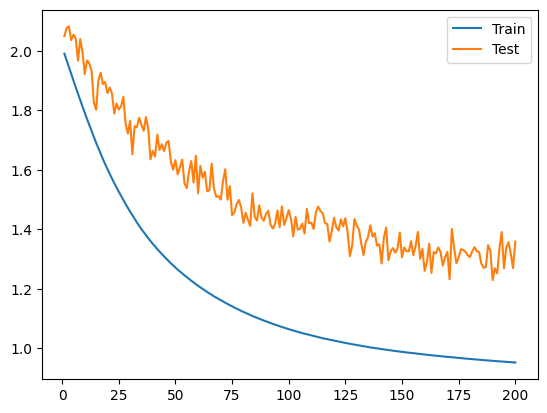

In [278]:
import matplotlib.pyplot as plt 

# Epoch: 199
# Train loss 1.0964075326919556
# Test loss 1.497989535331726

# Если среднее по датасету добавить
# Epoch: 199
# Train loss 0.9525358080863953
# Test loss 1.3584315776824951

x = list(range(1, num_epochs + 1))

plt.plot(x, train_loss, label="Train")
plt.plot(x, test_loss, label = "Test")
plt.legend(loc='best')
plt.show()